# TEAM NAME ETC

# Overview

Our task is to build an inferential linear regression model. Our model will help our stakeholder understand King County home valuations better. We will follow the assumptions of linear regression which are linearity, independence, normality, and homoscedasticity. We will also strive to have a high R^2 value, signaling that our parameters are explaining much of the total variance in house sales.

# Business Understanding

Our stakeholder is a King County real estate agency. 

We want to provide our client with the math and reasoning behind local home valuations. We will discuss the important features that affect a valuation based on analysis of previous home sales in the area. We will take a look at factors such as home size & space, location, upgrades & updates, age & condition, and market factors. Market factors include local market conditions, macroeconomics, and interest rates. 

Through our analysis, our stakeholder will have an understanding of the conditions of the Seattle and King County real estate market.

# Data Understanding

The data that we used is King County House Sales data from the King County assessor website. Our data set includes info about homes that sold between May 2nd, 2014 to May 24th, 2015. The target variable is price. We removed properties that were outside of three standard deviations of the mean price. We also removed typos.

## *Loading our data*

In [398]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [399]:
df = pd.read_csv('data/kc_house_data.csv')

## Column formatting & Dealing with missing values

### *Renovated < 10 yrs*

In [400]:
df['yr_renovated'] = df['yr_renovated'].fillna(0.0)
df['renovated_less_10yrs'] = df['yr_renovated'] > 2010.0
df['renovated_less_10yrs'] = df['renovated_less_10yrs'].astype('int64')

### *Condition Column*

In [401]:
df['condition'].replace('Poor', '1', inplace=True)
df['condition'].replace('Fair', '2', inplace=True)
df['condition'].replace('Average', '3', inplace=True)
df['condition'].replace('Good', '4', inplace=True)
df['condition'].replace('Very Good', '5', inplace=True)
df['condition'] = df['condition'].astype(np.int64)

### *View Column*

In [402]:
df['view'].fillna('NONE', inplace=True)
df['view'].replace('NONE', '0', inplace=True)
df['view'].replace('FAIR', '1', inplace=True)
df['view'].replace('AVERAGE', '2', inplace=True)
df['view'].replace('GOOD', '3', inplace=True)
df['view'].replace('EXCELLENT', '4', inplace=True)
df['view'] = df['view'].astype(np.int64)

### *Sqft Basement Column*

In [403]:
df['sqft_basement'].replace(to_replace='?', value='0', inplace=True)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'],errors='coerce')
df['has_basement'] = df['sqft_basement']
df.loc[df.has_basement > 0, 'has_basement'] = 1

### *Date Column*

In [404]:
# Converting to Datetime
df['date'] =  pd.to_datetime(df['date'], format='%m/%d/%Y')

### *Waterfront Column*

In [405]:
# Converting Waterfront to Binary
df['waterfront'] = df['waterfront'].fillna('0')
df['waterfront'].replace(to_replace='NO', value='0', inplace=True)
df['waterfront'].replace(to_replace='YES', value='1', inplace=True)
df['waterfront'] = pd.to_numeric(df['waterfront'],errors='coerce')

### *Grade Column*

In [406]:
# Converting Grade to Numeric
df['grade'] = df['grade'].str.slice(0,2).str.strip()
df['grade'] = df['grade'].astype(np.int64)

## *Dropping outliers*

In [407]:
#Dropping outliers
price_mean = np.mean(df['price'])
cut_off = np.std(df['price']) * 3
df.drop(df[df['price'] > price_mean + cut_off].index, inplace = True)
df.drop(df[df['price'] < price_mean - cut_off].index, inplace = True)
df.drop(df[df['bedrooms'] > 15].index, inplace=True)

In [408]:
df.shape

(21190, 23)

C:\Users\chris\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

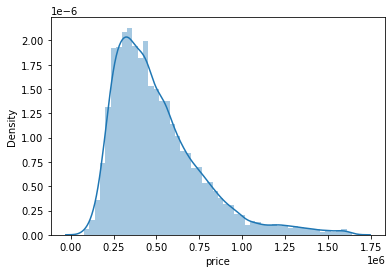

In [409]:
sns.distplot(df['price'])

# Modeling

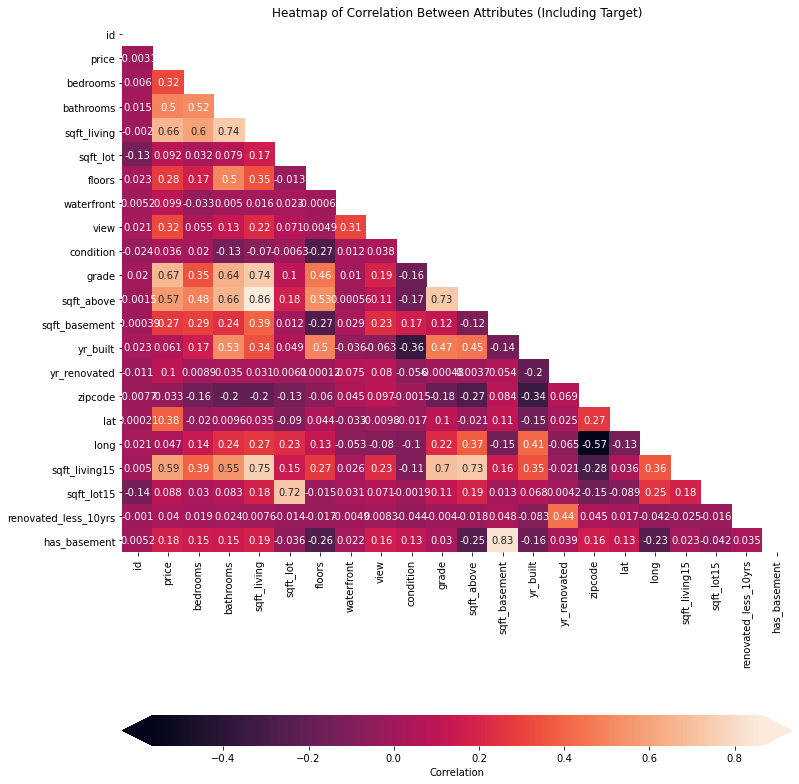

In [410]:
# heatmap_data = pd.concat([y_train, X_train], axis=1)
# corr = heatmap_data.corr()
corr = df.corr()
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 15))
# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

# Plotting Functions

In [447]:
def linearity_plot(x, y):
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
    cols = 1
    if x.shape[1] % 2 == 0:
        cols = 2
    elif x.shape[1] < 2:
        cols = 1
    else:
        cols = 3
    rows = 1
    if x.shape[1] // cols == 0:
        rows = 1
    elif x.shape[1] % cols > 0:
        rows = x.shape[1] // cols + 1
    else:
        rows = rows = x.shape[1] // cols 
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12,8), squeeze=False)
    fig.set_tight_layout(True)
    print(x.columns)
    for index, col in enumerate(x.columns):
        ax = axes[index//cols][index%cols]
        ax.scatter(x[col], y, alpha=0.2)
        ax.set_xlabel(col)
        ax.set_ylabel("listing price")

# Baseline Model

In [412]:
baseline_y = df['price']
baseline_X = df.drop(['price', 'id', 'date'], axis=1)

In [413]:
baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(baseline_X, baseline_y, random_state=42)

In [414]:
scaler = StandardScaler()
baseline_X_train_scaled = scaler.fit_transform(baseline_X_train)
baseline_X_test_scaled = scaler.fit_transform(baseline_X_test)

baseline_X_train_scaled = pd.DataFrame(baseline_X_train_scaled)
baseline_X_train_scaled.columns = baseline_X.columns
baseline_X_test_scaled = pd.DataFrame(baseline_X_test_scaled)
baseline_X_test_scaled.columns = baseline_X.columns

In [415]:
print(f'Train Mean: {baseline_y_train.mean()}, Test Mean: {baseline_y_test.mean()}')

Train Mean: 505325.3087087843, Test Mean: 512039.5039637599


In [416]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(baseline_X_train_scaled, baseline_y_train)
dummy_regr.predict(baseline_X_train_scaled)
dummy_regr.score(baseline_X_test_scaled, baseline_y_test)

-0.0006578942651938036

## *Interpreting the baseline model*

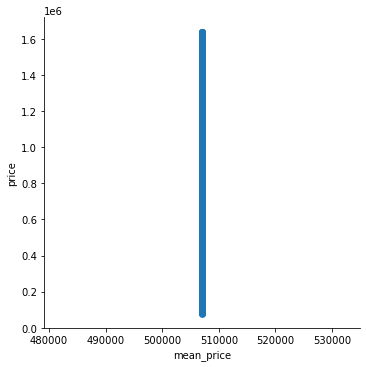

In [417]:
#LINEARITY
df['mean_price']=df['price'].mean()
sns.lmplot(x='mean_price', y='price', data=df);

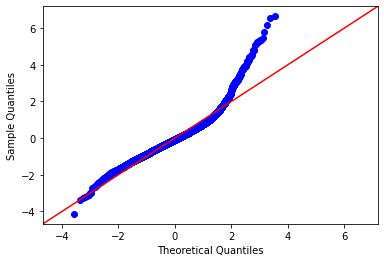

In [418]:
#NORMALITY
# Normal distribution of errors check
baseline_model = LinearRegression()
baseline_model.fit(baseline_X_train_scaled, baseline_y_train)
baseline_model.score(baseline_X_test_scaled, baseline_y_test)
preds = baseline_model.predict(baseline_X_test_scaled)
residuals = (baseline_y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [419]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(baseline_X_train_scaled.values, i) for i in range(baseline_X_train_scaled.shape[1])]
pd.Series(vif, index=baseline_X_train_scaled.columns, name="Variance Inflation Factor")

bedrooms                  1.725757
bathrooms                 3.241837
sqft_living             149.768399
sqft_lot                  1.983351
floors                    2.066365
waterfront                1.101259
view                      1.278353
condition                 1.238958
grade                     3.206788
sqft_above              126.135223
sqft_basement            40.923936
yr_built                  2.418925
yr_renovated              1.340859
zipcode                   1.674664
lat                       1.190267
long                      1.855483
sqft_living15             2.961611
sqft_lot15                2.017249
renovated_less_10yrs      1.230236
has_basement              3.692269
Name: Variance Inflation Factor, dtype: float64

In [420]:
#MULTICOLLINEARITY VIOLATED

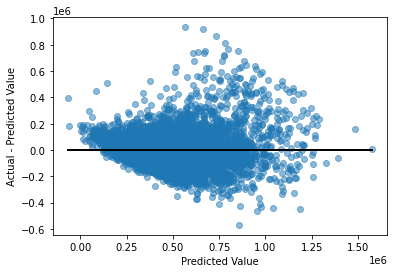

In [421]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(baseline_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

## First Model: Square Feet Living & Price

In [422]:
first_y = df["price"]
first_X = df.drop("price", axis=1)
first_formula = ['sqft_living']
first_X = first_X[first_formula]

In [423]:
first_X_train, first_X_test, first_y_train, first_y_test = train_test_split(first_X, first_y, random_state=42)

In [424]:
scaler = StandardScaler()
first_X_train_scaled = scaler.fit_transform(first_X_train)
first_X_test_scaled = scaler.fit_transform(first_X_test)

In [425]:
first_model = LinearRegression()

# Fit the model on X_train_final and y_train
first_model.fit(first_X_train_scaled, first_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
first_model.score(first_X_test_scaled, first_y_test)

0.43731617821047075

In [426]:
print(f'Train RMSE: {mean_squared_error(first_y_train, first_model.predict(first_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(first_y_test, first_model.predict(first_X_test_scaled), squared=False)}')

Train RMSE: 193057.1182615235
Test RMSE: 196357.78783753506


In [427]:
sm.OLS(first_y_train, sm.add_constant(first_X_train_scaled)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                 1.264e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:32:16   Log-Likelihood:            -2.1597e+05
No. Observations:               15892   AIC:                         4.319e+05
Df Residuals:                   15890   BIC:                         4.320e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.053e+05   1531.524    329.949      0.000    5.02e+05    5.08e+05
x1          1.722e+05   1531.524    112.406      0.000    1.69e+05    1.75e+05
==============================================================================
Omnibus:                     2579.728   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5446.188
Skew:                           0.969   Prob(JB):                         0.00
Kurtosis:                       5.113   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [428]:
first_X_train_scaled = pd.DataFrame(first_X_train_scaled)
first_X_train_scaled.columns = first_X.columns
first_X_test_scaled = pd.DataFrame(first_X_test_scaled)
first_X_test_scaled.columns = first_X.columns

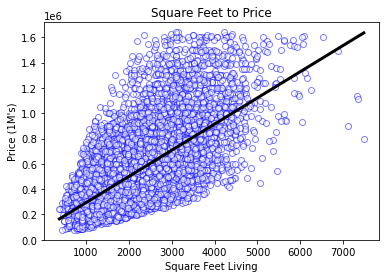

In [429]:
fig, ax = plt.subplots()
ax.scatter(first_X_train[first_formula], first_y_train, alpha=0.5, color ='white', edgecolor='blue')
ax.set_xlabel('Square Feet Living')
ax.set_ylabel("Price (1M's)")
ax.set_title('Square Feet to Price')
plt.plot(np.unique(first_X_train['sqft_living']), np.poly1d(np.polyfit(first_X_train['sqft_living'], first_y_train, 1))
         (np.unique(first_X_train['sqft_living'])),linewidth=3.0,color='black');


## *Interpreting the first model*

Index(['sqft_living'], dtype='object')


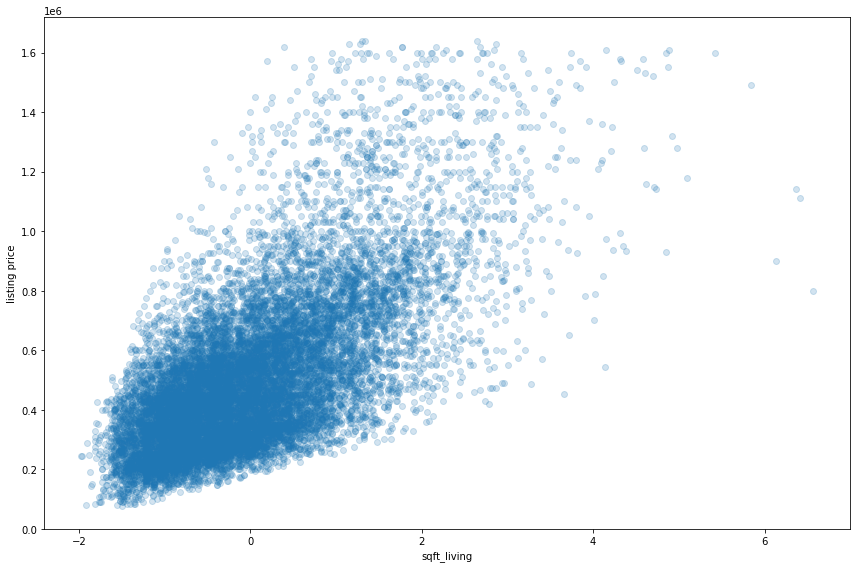

In [448]:
#LINEARITY
linearity_plot(first_X_train_scaled, first_y_train)

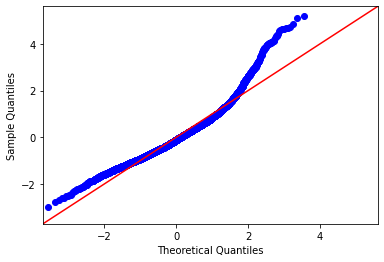

In [431]:
#NORMALITY
import scipy.stats as stats
preds_1st = first_model.predict(first_X_test_scaled)
residuals = (first_y_test - preds_1st)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [432]:
#MULTICOLLINEARITY NOT APPLICABLE

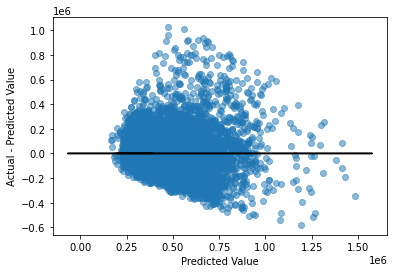

In [433]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()
ax.scatter(preds_1st, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(first_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

# GOOD MODEL sqft living and Grade

In [434]:
good_y = df["price"]
good_X = df.drop("price", axis=1)
good_formula = ['sqft_living', 'grade']
good_X = good_X[good_formula]

In [435]:
good_X_train, good_X_test, good_y_train, good_y_test = train_test_split(good_X, good_y, random_state=42)

In [436]:
scaler = StandardScaler()
good_X_train_scaled = scaler.fit_transform(good_X_train)
good_X_test_scaled = scaler.fit_transform(good_X_test)

In [437]:
good_model = LinearRegression()

# Fit the model on X_train_final and y_train
good_model.fit(good_X_train_scaled, good_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
good_model.score(good_X_test_scaled, good_y_test)

0.5055171743715028

In [438]:
print(f'Train RMSE: {mean_squared_error(good_y_train, good_model.predict(good_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(good_y_test, good_model.predict(good_X_test_scaled), squared=False)}')

Train RMSE: 179752.17213315246
Test RMSE: 184073.60699324406


In [439]:
sm.OLS(good_y_train, sm.add_constant(good_X_train_scaled)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     8507.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:32:16   Log-Likelihood:            -2.1483e+05
No. Observations:               15892   AIC:                         4.297e+05
Df Residuals:                   15889   BIC:                         4.297e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.053e+05   1426.021    354.360      0.000    5.03e+05    5.08e+05
x1          9.503e+04   2114.747     44.936      0.000    9.09e+04    9.92e+04
x2          1.044e+05   2114.747     49.388      0.000       1e+05    1.09e+05
==============================================================================
Omnibus:                     2717.815   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5976.508
Skew:                           1.000   Prob(JB):                         0.00
Kurtosis:                       5.242   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## ASSUMPTIONS

RangeIndex(start=0, stop=2, step=1)


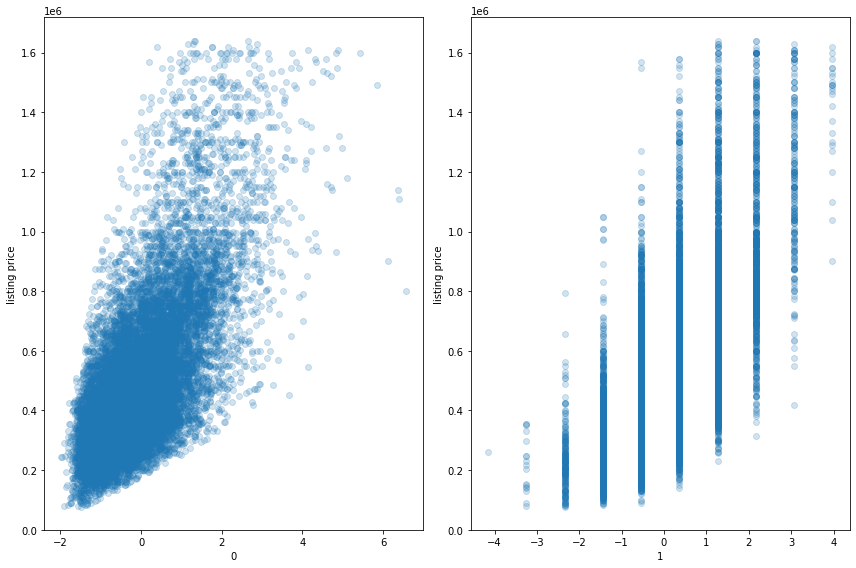

In [449]:
linearity_plot(good_X_train_scaled, good_y_train)

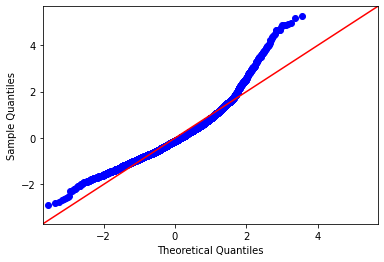

In [441]:
#NORMALITY
good_X_test_scaled = pd.DataFrame(good_X_test_scaled)
preds_good = good_model.predict(good_X_test_scaled)
residuals = (good_y_test - preds_good)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [442]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(good_X_train_scaled.values, i) for i in range(good_X_train_scaled.shape[1])]
pd.Series(vif, index=good_X_train_scaled.columns, name="Variance Inflation Factor")

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_good, residuals, alpha=0.5)
ax.plot(preds_good, [0 for i in range(len(good_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [ ]:
#HOMOSCEDASTICITY BORDERLINE

# Great Model sqft_living, grade, lat

In [ ]:
great_y = df["price"]
great_X = df.drop("price", axis=1)
great_formula = ['sqft_living', 'grade', 'lat']
great_X = great_X[great_formula]

In [ ]:
great_X_train, great_X_test, great_y_train, great_y_test = train_test_split(great_X, great_y, random_state=42)

In [ ]:
scaler = StandardScaler()
great_X_train_scaled = scaler.fit_transform(great_X_train)
great_X_test_scaled = scaler.fit_transform(great_X_test)

In [ ]:
great_model = LinearRegression()

# Fit the model on X_train_final and y_train
great_model.fit(great_X_train_scaled, great_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
great_model.score(great_X_test_scaled, great_y_test)

In [ ]:
print(f'Train RMSE: {mean_squared_error(great_y_train, great_model.predict(great_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(great_y_test, great_model.predict(great_X_test_scaled), squared=False)}')

In [ ]:
sm.OLS(good_y_train, sm.add_constant(great_X_train_scaled)).fit().summary()

## Assumptions

In [ ]:
# Linearity
linearity_plot(great_X_train_scaled, great_y_train)

In [ ]:
#NORMALITY
great_X_test_scaled = pd.DataFrame(great_X_test_scaled)
preds_great = great_model.predict(great_X_test_scaled)
residuals = (great_y_test - preds_great)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [ ]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(great_X_train_scaled.values, i) for i in range(great_X_train_scaled.shape[1])]
pd.Series(vif, index=great_X_train_scaled.columns, name="Variance Inflation Factor")

In [ ]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_great, residuals, alpha=0.5)
ax.plot(preds_great, [0 for i in range(len(great_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [ ]:
#MAYBE ISSUES?

# Awesome Model sqft_living, grade, lat, view

In [ ]:
awesome_y = df["price"]
awesome_X = df.drop("price", axis=1)
awesome_formula = ['sqft_living', 'grade', 'lat', 'view']
awesome_X = awesome_X[awesome_formula]

In [ ]:
awesome_X_train, awesome_X_test, awesome_y_train, awesome_y_test = train_test_split(awesome_X, awesome_y, random_state=42)

In [ ]:
scaler = StandardScaler()
awesome_X_train_scaled = scaler.fit_transform(awesome_X_train)
awesome_X_test_scaled = scaler.fit_transform(awesome_X_test)

In [ ]:
awesome_model = LinearRegression()

# Fit the model on X_train_final and y_train
awesome_model.fit(awesome_X_train_scaled, awesome_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
awesome_model.score(awesome_X_test_scaled, awesome_y_test)

In [ ]:
print(f'Train RMSE: {mean_squared_error(awesome_y_train, awesome_model.predict(awesome_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(awesome_y_test, awesome_model.predict(awesome_X_test_scaled), squared=False)}')

In [ ]:
sm.OLS(awesome_y_train, sm.add_constant(awesome_X_train_scaled)).fit().summary()

In [ ]:
# Linearity
linearity_plot(awesome_X_train_scaled, awesome_y_train)


In [ ]:
#NORMALITY
awesome_X_test_scaled = pd.DataFrame(awesome_X_test_scaled)
preds_awesome = awesome_model.predict(awesome_X_test_scaled)
residuals = (awesome_y_test - preds_awesome)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [ ]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(awesome_X_train_scaled.values, i) for i in range(awesome_X_train_scaled.shape[1])]
pd.Series(vif, index=awesome_X_train_scaled.columns, name="Variance Inflation Factor")

In [ ]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_awesome, residuals, alpha=0.5)
ax.plot(preds_awesome, [0 for i in range(len(awesome_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

# Amazing Model sqft_living, grade, lat, view, age

In [ ]:
df['age'] = 2021 - df['yr_built'] 
df['age']

In [ ]:
amazing_y = df["price"]
amazing_X = df.drop("price", axis=1)
amazing_formula = ['sqft_living', 'grade', 'lat', 'view', 'age']
amazing_X = amazing_X[amazing_formula]

In [ ]:
amazing_X_train, amazing_X_test, amazing_y_train, amazing_y_test = train_test_split(amazing_X, amazing_y, random_state=42)

In [ ]:
scaler = StandardScaler()
amazing_X_train_scaled = scaler.fit_transform(amazing_X_train)
amazing_X_test_scaled = scaler.fit_transform(amazing_X_test)

In [ ]:
amazing_model = LinearRegression()

# Fit the model on X_train_final and y_train
amazing_model.fit(amazing_X_train_scaled, amazing_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
amazing_model.score(amazing_X_test_scaled, amazing_y_test)

In [ ]:
print(f'Train RMSE: {mean_squared_error(amazing_y_train, amazing_model.predict(amazing_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(amazing_y_test, amazing_model.predict(amazing_X_test_scaled), squared=False)}')

In [ ]:
sm.OLS(amazing_y_train, sm.add_constant(amazing_X_train_scaled)).fit().summary()

## Assumptions

RangeIndex(start=0, stop=5, step=1)


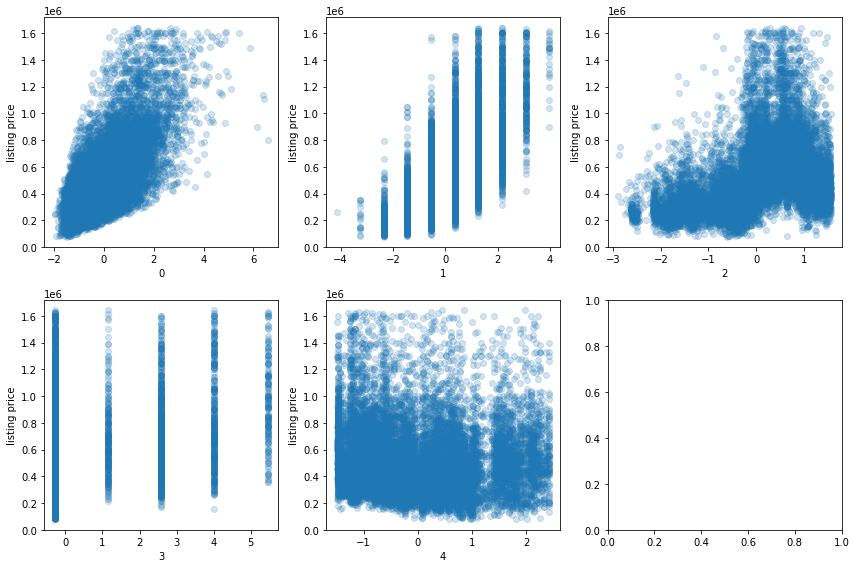

In [450]:
# Linearity
linearity_plot(amazing_X_train_scaled, amazing_y_train)

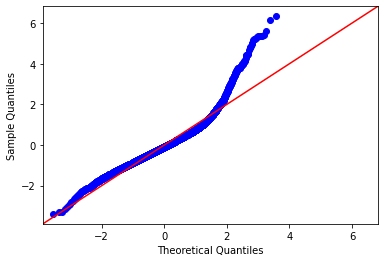

In [444]:
#NORMALITY
amazing_X_test_scaled = pd.DataFrame(amazing_X_test_scaled)
preds_amazing = amazing_model.predict(amazing_X_test_scaled)
residuals = (amazing_y_test - preds_amazing)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [88]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(amazing_X_train_scaled.values, i) for i in range(amazing_X_train_scaled.shape[1])]
pd.Series(vif, index=amazing_X_train_scaled.columns, name="Variance Inflation Factor")

sqft_living    2.239512
grade          2.632073
lat            1.077274
view           1.093301
age            1.409408
Name: Variance Inflation Factor, dtype: float64

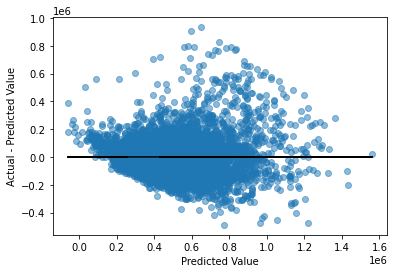

In [89]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_amazing, residuals, alpha=0.5)
ax.plot(preds_amazing, [0 for i in range(len(amazing_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

# Regression Results

# Conclusion